## Установка библиотек

In [1]:
!pip install mrjob
!pip install pyarrow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.6/439.6 KB 1.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.4/35.4 MB 1.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.2/14.2 MB 1.2 MB/s eta 0:00:0000:0100:01


## Загрузка данных

Создаем папку для будущих данных

In [156]:
!hadoop fs -mkdir /starwars

2023-11-29 21:30:50 WARN  NativeCodeLoader:60 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [157]:
!hadoop fs -ls /

2023-11-29 21:30:54 WARN  NativeCodeLoader:60 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Found 3 items
drwxr-xr-x   - root supergroup          0 2023-11-29 21:30 /starwars
drwx-wx-wx   - root supergroup          0 2023-11-29 18:57 /tmp
drwxr-xr-x   - root supergroup          0 2023-11-29 18:57 /user


Загружаем файлы с данными из локальной файловой системы на hdfs

In [158]:
!hadoop fs -put ./archive/SW_EpisodeIV.txt /starwars
!hadoop fs -put ./archive/SW_EpisodeV.txt /starwars
!hadoop fs -put ./archive/SW_EpisodeVI.txt /starwars

2023-11-29 21:31:28 WARN  NativeCodeLoader:60 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
2023-11-29 21:31:29 WARN  NativeCodeLoader:60 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
2023-11-29 21:31:30 WARN  NativeCodeLoader:60 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Проверим, что файлики действительно появились в hdfs

In [159]:
!hadoop fs -ls /starwars

2023-11-29 21:31:41 WARN  NativeCodeLoader:60 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Found 3 items
-rw-r--r--   3 root supergroup      78255 2023-11-29 21:31 /starwars/SW_EpisodeIV.txt
-rw-r--r--   3 root supergroup      55464 2023-11-29 21:31 /starwars/SW_EpisodeV.txt
-rw-r--r--   3 root supergroup      48153 2023-11-29 21:31 /starwars/SW_EpisodeVI.txt


### Пути до файлов

Для удобства вынесем пути до файлов в переменные

In [160]:
# original data files
original_e4 = './archive/SW_EpisodeIV.txt'
original_e5 = './archive/SW_EpisodeV.txt'
original_e6 = './archive/SW_EpisodeVI.txt'

# hdfs data files
hdfs_e4 = 'hdfs://namenode:8020/starwars/SW_EpisodeIV.txt'
hdfs_e5 = 'hdfs://namenode:8020/starwars/SW_EpisodeV.txt'
hdfs_e6 = 'hdfs://namenode:8020/starwars/SW_EpisodeVI.txt'

## Задание 1

## Скрипт-решение: топ самых говорливых персонажей

In [161]:
%%file most_talkative_characters.py
# %%file is an Ipython magic function that saves the code cell as a file

from mrjob.job import MRJob
from mrjob.step import MRStep

TOP_N = 20

class MRMostTalkativeCharacters(MRJob):
    def steps(self):
        return [
            MRStep(mapper=self.mapper_get_characters,
                   combiner=self.combiner_count_phrases,
                   reducer=self.reducer_count_phrases),
            MRStep(reducer=self.reducer_top_talkative_characters)
        ]

    def mapper_get_characters(self, _, line):
        line_words = line.replace('"', '').split()
        character = line_words[1]
        yield (character, 1)

    def combiner_count_phrases(self, character, phrases_counts):
        # optimization: sum the characters we've seen so far
        yield (character, sum(phrases_counts))

    def reducer_count_phrases(self, character, phrases_counts):
        # send all (character, phrases_counts) pairs to the same reducer.
        yield None, (character, sum(phrases_counts))

    # discard the key; it is just None
    def reducer_top_talkative_characters(self, _, character_phrases_count_pairs):
        # each item of character_phrases_count_pairs is (character, total_phrases_count)
        # convert to list bc 'generator' object is not subscriptable
        character_phrases_count_pairs = list(character_phrases_count_pairs)
        
        # sort by total phrases count
        character_phrases_count_pairs.sort(
            key=lambda pair: pair[1],
            reverse=True
        )

        # get top N talkative characters
        top_talkative_characters = character_phrases_count_pairs[:TOP_N]
        
        # return the result
        for character_count_pair in top_talkative_characters:
            yield character_count_pair


if __name__ == '__main__':
    MRMostTalkativeCharacters.run()

Overwriting most_talkative_characters.py


## Локальное тестирование

### Запуск скриптов

In [162]:
# task-1 local results paths
t1_local_res_e4 = './results/task-1/local/SW_EpisodeIV_res.txt'
t1_local_res_e5 = './results/task-1/local/SW_EpisodeV_res.txt'
t1_local_res_e6 = './results/task-1/local/SW_EpisodeVI_res.txt'
t1_local_res_all = './results/task-1/local/SW_All_Episodes_res.txt'

По каждому эпизоду

In [163]:
!python3 most_talkative_characters.py $original_e4 > $t1_local_res_e4

No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /tmp/most_talkative_characters.root.20231129.183201.187088
Running step 1 of 2...
Running step 2 of 2...
job output is in /tmp/most_talkative_characters.root.20231129.183201.187088/output
Streaming final output from /tmp/most_talkative_characters.root.20231129.183201.187088/output...
Removing temp directory /tmp/most_talkative_characters.root.20231129.183201.187088...


In [164]:
!python3 most_talkative_characters.py $original_e5 > $t1_local_res_e5

No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /tmp/most_talkative_characters.root.20231129.183203.499432
Running step 1 of 2...
Running step 2 of 2...
job output is in /tmp/most_talkative_characters.root.20231129.183203.499432/output
Streaming final output from /tmp/most_talkative_characters.root.20231129.183203.499432/output...
Removing temp directory /tmp/most_talkative_characters.root.20231129.183203.499432...


In [165]:
!python3 most_talkative_characters.py $original_e6 > $t1_local_res_e6

No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /tmp/most_talkative_characters.root.20231129.183205.471834
Running step 1 of 2...
Running step 2 of 2...
job output is in /tmp/most_talkative_characters.root.20231129.183205.471834/output
Streaming final output from /tmp/most_talkative_characters.root.20231129.183205.471834/output...
Removing temp directory /tmp/most_talkative_characters.root.20231129.183205.471834...


По всем трем эпизодам

In [166]:
!python3 most_talkative_characters.py $original_e4 $original_e5 $original_e6 > $t1_local_res_all

No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /tmp/most_talkative_characters.root.20231129.183211.226420
Running step 1 of 2...
Running step 2 of 2...
job output is in /tmp/most_talkative_characters.root.20231129.183211.226420/output
Streaming final output from /tmp/most_talkative_characters.root.20231129.183211.226420/output...
Removing temp directory /tmp/most_talkative_characters.root.20231129.183211.226420...


## Тестирование на кластере

### Изменение конфигурации

Увеличим число mapper'ов и reducer'ов, изменив конфигурацию

In [167]:
%%file config-t1.conf

runners:
  hadoop: # also works for emr runner
    jobconf:
      mapreduce.job.maps: 2
      mapreduce.job.reduces: 2

Overwriting config-t1.conf


### Запуск скриптов

In [168]:
# task-1 hdfs results paths
t1_hdfs_res_e4 = '/starwars/results/task-1/SW_EpisodeIV_res.txt'
t1_hdfs_res_e5 = '/starwars/results/task-1/SW_EpisodeV_res.txt'
t1_hdfs_res_e6 = '/starwars/results/task-1/SW_EpisodeVI_res.txt'
t1_hdfs_res_all = '/starwars/results/task-1/SW_All_Episodes_res.txt'

По каждому эпизоду. Результаты сохраняем в файловую систему hdfs.

In [169]:
!python3 most_talkative_characters.py -r hadoop $hdfs_e4 --conf-path config-t1.conf --output $t1_hdfs_res_e4

Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 3.3.6
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-3.3.6.jar
Creating temp directory /tmp/most_talkative_characters.root.20231129.183239.618428
uploading working dir files to hdfs:///user/root/tmp/mrjob/most_talkative_characters.root.20231129.183239.618428/files/wd...
Copying other local files to hdfs:///user/root/tmp/mrjob/most_talkative_characters.root.20231129.183239.618428/files/
Running step 1 of 2...
  Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
  packageJobJar: [/tmp/hadoop-unjar71133078064757154/] [] /tmp/streamjob5788522788479100486.jar tmpDir=null
  Connecting to ResourceManager at resourcemanager/172.18.0.3:8032
  Connecting to ResourceManager at resourcemanager/172.18.0.3:8032
  Disabling Erasure Coding for path: /tmp/had

In [170]:
!python3 most_talkative_characters.py -r hadoop $hdfs_e5 --conf-path config-t1.conf --output $t1_hdfs_res_e5

Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 3.3.6
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-3.3.6.jar
Creating temp directory /tmp/most_talkative_characters.root.20231129.183352.087034
uploading working dir files to hdfs:///user/root/tmp/mrjob/most_talkative_characters.root.20231129.183352.087034/files/wd...
Copying other local files to hdfs:///user/root/tmp/mrjob/most_talkative_characters.root.20231129.183352.087034/files/
Running step 1 of 2...
  Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
  packageJobJar: [/tmp/hadoop-unjar8581318806081350310/] [] /tmp/streamjob5830183056996958284.jar tmpDir=null
  Connecting to ResourceManager at resourcemanager/172.18.0.3:8032
  Connecting to ResourceManager at resourcemanager/172.18.0.3:8032
  Disabling Erasure Coding for path: /tmp/h

In [171]:
!python3 most_talkative_characters.py -r hadoop $hdfs_e6 --conf-path config-t1.conf --output $t1_hdfs_res_e6

Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 3.3.6
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-3.3.6.jar
Creating temp directory /tmp/most_talkative_characters.root.20231129.183434.162679
uploading working dir files to hdfs:///user/root/tmp/mrjob/most_talkative_characters.root.20231129.183434.162679/files/wd...
Copying other local files to hdfs:///user/root/tmp/mrjob/most_talkative_characters.root.20231129.183434.162679/files/
Running step 1 of 2...
  Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
  packageJobJar: [/tmp/hadoop-unjar8301660513370636041/] [] /tmp/streamjob936642036607338949.jar tmpDir=null
  Connecting to ResourceManager at resourcemanager/172.18.0.3:8032
  Connecting to ResourceManager at resourcemanager/172.18.0.3:8032
  Disabling Erasure Coding for path: /tmp/ha

По всем эпизодам

In [174]:
!python3 most_talkative_characters.py -r hadoop $hdfs_e4 $hdfs_e5 $hdfs_e6 --conf-path config-t1.conf --output $t1_hdfs_res_all

Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 3.3.6
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-3.3.6.jar
Creating temp directory /tmp/most_talkative_characters.root.20231129.183550.946613
uploading working dir files to hdfs:///user/root/tmp/mrjob/most_talkative_characters.root.20231129.183550.946613/files/wd...
Copying other local files to hdfs:///user/root/tmp/mrjob/most_talkative_characters.root.20231129.183550.946613/files/
Running step 1 of 2...
  Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
  packageJobJar: [/tmp/hadoop-unjar4449862089091554044/] [] /tmp/streamjob9055322147879468631.jar tmpDir=null
  Connecting to ResourceManager at resourcemanager/172.18.0.3:8032
  Connecting to ResourceManager at resourcemanager/172.18.0.3:8032
  Disabling Erasure Coding for path: /tmp/h

### Просмотр результатов выполнения

In [175]:
!hadoop fs -cat /starwars/results/task-1/SW_All_Episodes_res.txt/part-00000

2023-11-29 21:37:01 WARN  NativeCodeLoader:60 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
"LUKE"	494
"HAN"	460
"THREEPIO"	301
"LEIA"	227
"VADER"	140
"BEN"	115
"LANDO"	101
"RED"	52
"YODA"	49
"EMPEROR"	44
"BIGGS"	34
"WEDGE"	33
"PIETT"	31
"TARKIN"	28
"JABBA"	26
"OWEN"	25
"GOLD"	23
"CREATURE"	22
"TROOPER"	20
"OFFICER"	14


In [176]:
!hadoop fs -cat /starwars/results/task-1/SW_All_Episodes_res.txt/part-00001

2023-11-29 21:37:11 WARN  NativeCodeLoader:60 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Все успешно. Результаты попали в одну часть.

### Скачивание файлов

Скачаем полученные в результате тестирования файлы локально на компьютер

In [179]:
!hadoop fs -get hdfs://namenode:8020/starwars/results/task-1/SW_EpisodeIV_res.txt ./results/task-1/hdfs/SW_EpisodeIV_res
!hadoop fs -get hdfs://namenode:8020/starwars/results/task-1/SW_EpisodeV_res.txt ./results/task-1/hdfs/SW_EpisodeV_res
!hadoop fs -get hdfs://namenode:8020/starwars/results/task-1/SW_EpisodeVI_res.txt ./results/task-1/hdfs/SW_EpisodeVI_res
!hadoop fs -get hdfs://namenode:8020/starwars/results/task-1/SW_All_Episodes_res.txt ./results/task-1/hdfs/SW_All_Episodes_res

2023-11-29 21:39:58 WARN  NativeCodeLoader:60 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
2023-11-29 21:40:00 WARN  NativeCodeLoader:60 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
2023-11-29 21:40:01 WARN  NativeCodeLoader:60 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
2023-11-29 21:40:02 WARN  NativeCodeLoader:60 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Построение графиков

In [180]:
from typing import Tuple, List

In [181]:
def results_parsing(res_file_path: str) -> Tuple[List, List]:
    characters = []
    phrases_counts = []

    with open(res_file_path) as res_file:
        for line in res_file:
            line_words = line.split('\t')

            character = line_words[0].replace('"', '')
            characters.append(character)
            
            phrases_count = int(line_words[1].replace('\n', ''))
            phrases_counts.append(phrases_count)
    return characters, phrases_counts

In [32]:
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 1.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 KB 1.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 876.6 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.2/293.2 KB 1.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 1.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 1.2 MB/s eta 0:00:0000:0100:01


In [266]:
from matplotlib import pyplot as plt

def build_graphic(characters: List, phrases_counts: List):
    plt.figure(figsize=(20,5))
    plt.bar(characters, phrases_counts, width=0.6)
    plt.xlabel('Character')
    plt. xticks(fontsize=8)
    plt.ylabel('Number of phrases')
    plt.title('Characters phrases counts')
    plt.grid()
    plt.show()

In [267]:
def results_graphic(res_file_path: str):
    characters, phrases_counts = results_parsing(res_file_path)
    build_graphic(characters, phrases_counts)

Построим графики для файлов с результатами

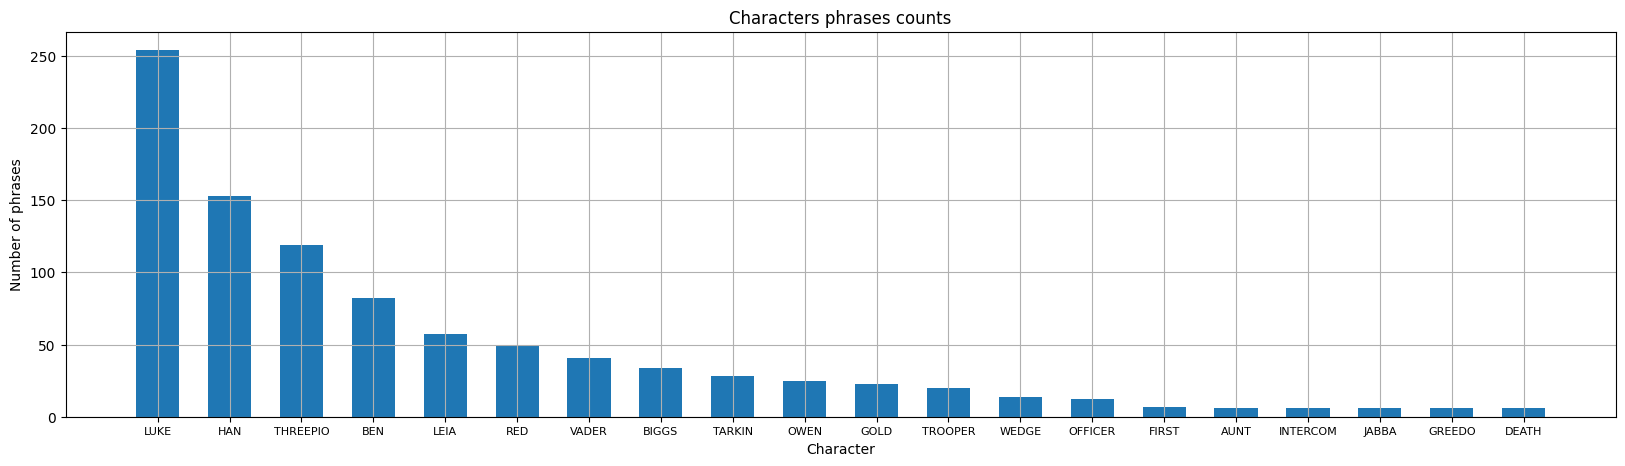

In [268]:
results_graphic(t1_local_res_e4)

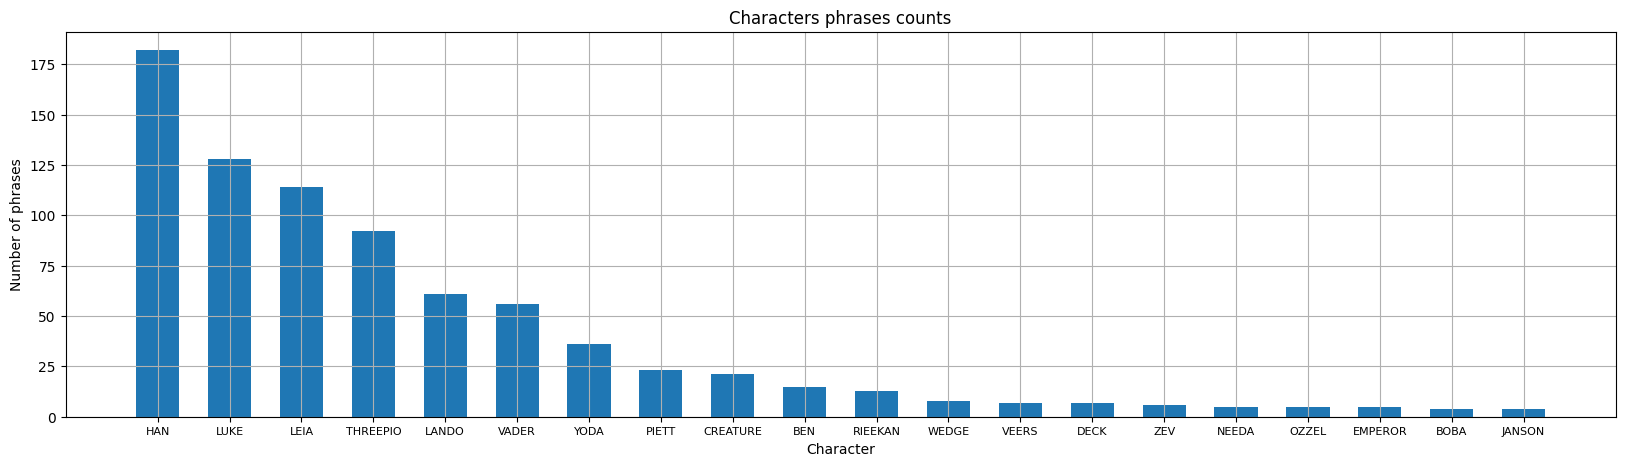

In [269]:
results_graphic(t1_local_res_e5)

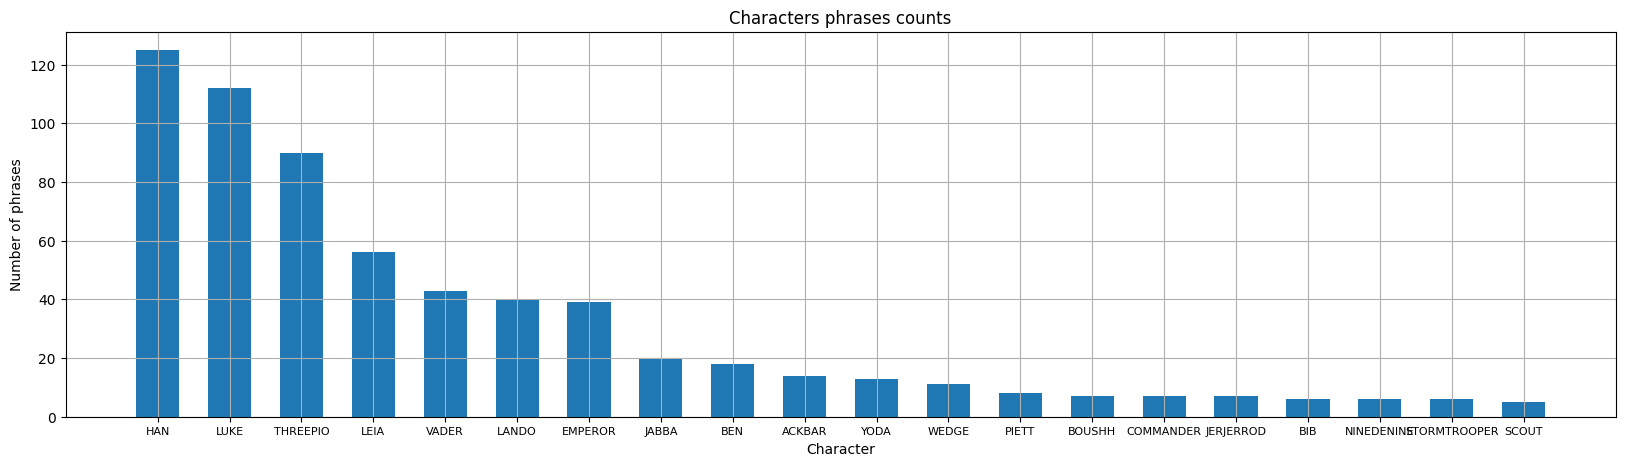

In [270]:
results_graphic(t1_local_res_e6)

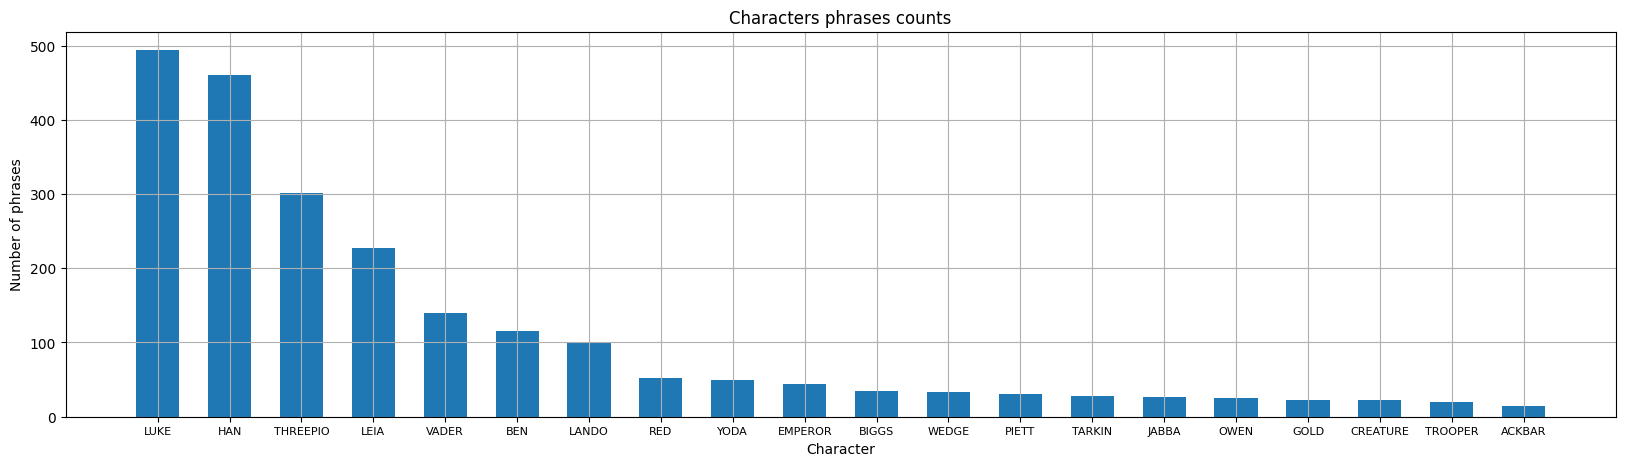

In [271]:
results_graphic(t1_local_res_all)

## Задание 2

## Скрипт-решение: самая длинная фраза каждого персонажа

In [207]:
%%file longest_character_phrase.py
# %%file is an Ipython magic function that saves the code cell as a file

from mrjob.job import MRJob
from mrjob.step import MRStep

class MRLongestCharacterPhrase(MRJob):
    def steps(self):
        return [
            MRStep(mapper=self.mapper_get_character_phrase,
                   combiner=self.combiner_longest_phrase,
                   reducer=self.reducer_longest_phrase),
            MRStep(reducer=self.reducer_sort_characters_by_phrase_len)
        ]

    def mapper_get_character_phrase(self, _, line):
        line_words = line.replace('"', '').split()
        character = line_words[1]
        phrase = ' '.join(line_words[2:])
        yield (character, phrase)

    def combiner_longest_phrase(self, character, phrases):
        # optimization: longest character phrase we've seen so far
        longest_character_phrase = max(phrases, key=len)
        yield (character, longest_character_phrase)

    def reducer_longest_phrase(self, character, longest_phrases):
        # the longest character phrase among all data
        longest_character_phrase = max(longest_phrases, key=len)
        yield None, (character, longest_character_phrase)

    # discard the key; it is just None
    def reducer_sort_characters_by_phrase_len(self, _, character_longest_phrase_pairs):
        # each item of character_longest_phrase_pairs is (character, longest_phrase)
        # convert to list bc 'generator' object is not subscriptable
        character_longest_phrase_pairs = list(character_longest_phrase_pairs)
        
        # sort by total phrases count
        character_longest_phrase_pairs.sort(
            key=lambda pair: len(pair[1]),
            reverse=True
        )

        # return the result
        for character_phrase_pair in character_longest_phrase_pairs:
            yield character_phrase_pair


if __name__ == '__main__':
    MRLongestCharacterPhrase.run()

Overwriting longest_character_phrase.py


## Локальное тестирование

### Запуск скриптов

In [208]:
# task-2 local results paths
t2_local_res_e4 = './results/task-2/local/SW_EpisodeIV_res.txt'
t2_local_res_e5 = './results/task-2/local/SW_EpisodeV_res.txt'
t2_local_res_e6 = './results/task-2/local/SW_EpisodeVI_res.txt'
t2_local_res_all = './results/task-2/local/SW_All_Episodes_res.txt'

По каждому эпизоду

In [209]:
!python3 longest_character_phrase.py $original_e4 > $t2_local_res_e4

No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /tmp/longest_character_phrase.root.20231129.184340.118303
Running step 1 of 2...
Running step 2 of 2...
job output is in /tmp/longest_character_phrase.root.20231129.184340.118303/output
Streaming final output from /tmp/longest_character_phrase.root.20231129.184340.118303/output...
Removing temp directory /tmp/longest_character_phrase.root.20231129.184340.118303...


In [210]:
!python3 longest_character_phrase.py $original_e5 > $t2_local_res_e5

No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /tmp/longest_character_phrase.root.20231129.184341.904408
Running step 1 of 2...
Running step 2 of 2...
job output is in /tmp/longest_character_phrase.root.20231129.184341.904408/output
Streaming final output from /tmp/longest_character_phrase.root.20231129.184341.904408/output...
Removing temp directory /tmp/longest_character_phrase.root.20231129.184341.904408...


In [211]:
!python3 longest_character_phrase.py $original_e6 > $t2_local_res_e6

No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /tmp/longest_character_phrase.root.20231129.184343.386716
Running step 1 of 2...
Running step 2 of 2...
job output is in /tmp/longest_character_phrase.root.20231129.184343.386716/output
Streaming final output from /tmp/longest_character_phrase.root.20231129.184343.386716/output...
Removing temp directory /tmp/longest_character_phrase.root.20231129.184343.386716...


По всем трем эпизодам

In [212]:
!python3 longest_character_phrase.py $original_e4 $original_e5 $original_e6 > $t2_local_res_all

No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /tmp/longest_character_phrase.root.20231129.184347.207483
Running step 1 of 2...
Running step 2 of 2...
job output is in /tmp/longest_character_phrase.root.20231129.184347.207483/output
Streaming final output from /tmp/longest_character_phrase.root.20231129.184347.207483/output...
Removing temp directory /tmp/longest_character_phrase.root.20231129.184347.207483...


## Тестирование на кластере

### Запуск скриптов

In [213]:
# task-2 hdfs results paths
t2_hdfs_res_e4 = '/starwars/results/task-2/SW_EpisodeIV_res.txt'
t2_hdfs_res_e5 = '/starwars/results/task-2/SW_EpisodeV_res.txt'
t2_hdfs_res_e6 = '/starwars/results/task-2/SW_EpisodeVI_res.txt'
t2_hdfs_res_all = '/starwars/results/task-2/SW_All_Episodes_res.txt'

По каждому эпизоду. Результаты сохраняем в файловую систему hdfs.

In [214]:
!python3 longest_character_phrase.py -r hadoop $hdfs_e4 --conf-path config-t1.conf --output $t2_hdfs_res_e4

Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 3.3.6
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-3.3.6.jar
Creating temp directory /tmp/longest_character_phrase.root.20231129.184355.872010
uploading working dir files to hdfs:///user/root/tmp/mrjob/longest_character_phrase.root.20231129.184355.872010/files/wd...
Copying other local files to hdfs:///user/root/tmp/mrjob/longest_character_phrase.root.20231129.184355.872010/files/
Running step 1 of 2...
  Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
  packageJobJar: [/tmp/hadoop-unjar3308074517190860628/] [] /tmp/streamjob841190316563234693.jar tmpDir=null
  Connecting to ResourceManager at resourcemanager/172.18.0.3:8032
  Connecting to ResourceManager at resourcemanager/172.18.0.3:8032
  Disabling Erasure Coding for path: /tmp/hadoo

In [215]:
!python3 longest_character_phrase.py -r hadoop $hdfs_e5 --conf-path config-t1.conf --output $t2_hdfs_res_e5

Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 3.3.6
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-3.3.6.jar
Creating temp directory /tmp/longest_character_phrase.root.20231129.184438.089559
uploading working dir files to hdfs:///user/root/tmp/mrjob/longest_character_phrase.root.20231129.184438.089559/files/wd...
Copying other local files to hdfs:///user/root/tmp/mrjob/longest_character_phrase.root.20231129.184438.089559/files/
Running step 1 of 2...
  Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
  packageJobJar: [/tmp/hadoop-unjar6944198054283870297/] [] /tmp/streamjob4283107340769929642.jar tmpDir=null
  Connecting to ResourceManager at resourcemanager/172.18.0.3:8032
  Connecting to ResourceManager at resourcemanager/172.18.0.3:8032
  Disabling Erasure Coding for path: /tmp/hado

In [216]:
!python3 longest_character_phrase.py -r hadoop $hdfs_e6 --conf-path config-t1.conf --output $t2_hdfs_res_e6

Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 3.3.6
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-3.3.6.jar
Creating temp directory /tmp/longest_character_phrase.root.20231129.184520.309710
uploading working dir files to hdfs:///user/root/tmp/mrjob/longest_character_phrase.root.20231129.184520.309710/files/wd...
Copying other local files to hdfs:///user/root/tmp/mrjob/longest_character_phrase.root.20231129.184520.309710/files/
Running step 1 of 2...
  Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
  packageJobJar: [/tmp/hadoop-unjar2907872008181697277/] [] /tmp/streamjob3402744933867803267.jar tmpDir=null
  Connecting to ResourceManager at resourcemanager/172.18.0.3:8032
  Connecting to ResourceManager at resourcemanager/172.18.0.3:8032
  Disabling Erasure Coding for path: /tmp/hado

По всем трем эпизодам

In [217]:
!python3 longest_character_phrase.py -r hadoop $hdfs_e4 $hdfs_e5 $hdfs_e6 --conf-path config-t1.conf --output $t2_hdfs_res_all

Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 3.3.6
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-3.3.6.jar
Creating temp directory /tmp/longest_character_phrase.root.20231129.184602.405240
uploading working dir files to hdfs:///user/root/tmp/mrjob/longest_character_phrase.root.20231129.184602.405240/files/wd...
Copying other local files to hdfs:///user/root/tmp/mrjob/longest_character_phrase.root.20231129.184602.405240/files/
Running step 1 of 2...
  Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
  packageJobJar: [/tmp/hadoop-unjar2933463162784295329/] [] /tmp/streamjob2726657569223105251.jar tmpDir=null
  Connecting to ResourceManager at resourcemanager/172.18.0.3:8032
  Connecting to ResourceManager at resourcemanager/172.18.0.3:8032
  Disabling Erasure Coding for path: /tmp/hado

### Просмотр результатов выполнения

In [218]:
!hadoop fs -cat /starwars/results/task-2/SW_All_Episodes_res.txt/part-00000

2023-11-29 21:46:46 WARN  NativeCodeLoader:60 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
"BEN"	"The Organa household was high-born and politically quite powerful in that system. Leia became a princess by virtue of lineage... no one knew she'd been adopted, of course. But it was a title without real power, since Alderaan had long been a democracy. Even so, the family continued to be politically powerful, and Leia, following in her foster father's path, became a senator as well. That's not all she became, of course... she became the leader of her cell in the Alliance against the corrupt Empire. And because she had diplomatic immunity, she was a vital link for getting information to the Rebel cause. That's what she was doing when her path crossed yours... for her foster parents had always told her to contact me on Tatooine, if her troubles became desperate."
"LEIA"	"General Kenobi, years ago you served my father in the Clone War

### Скачивание файлов

Скачаем полученные в результате тестирования файлы локально на компьютер

In [219]:
!hadoop fs -get hdfs://namenode:8020/starwars/results/task-2/SW_EpisodeIV_res.txt ./results/task-2/hdfs/SW_EpisodeIV_res.txt
!hadoop fs -get hdfs://namenode:8020/starwars/results/task-2/SW_EpisodeV_res.txt ./results/task-2/hdfs/SW_EpisodeV_res.txt
!hadoop fs -get hdfs://namenode:8020/starwars/results/task-2/SW_EpisodeVI_res.txt ./results/task-2/hdfs/SW_EpisodeVI_res.txt
!hadoop fs -get hdfs://namenode:8020/starwars/results/task-2/SW_All_Episodes_res.txt ./results/task-2/hdfs/SW_All_Episodes_res.txt

2023-11-29 21:46:47 WARN  NativeCodeLoader:60 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
2023-11-29 21:46:48 WARN  NativeCodeLoader:60 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
2023-11-29 21:46:49 WARN  NativeCodeLoader:60 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
2023-11-29 21:46:50 WARN  NativeCodeLoader:60 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Задание 3

In [220]:
!pip install nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 1.2 MB/s eta 0:00:0000:0100:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 KB 1.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 KB 1.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 KB 548.1 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.1/774.1 KB 1.2 MB/s eta 0:00:00a 0:00:01


### (Игрушечные примеры очистки данных)

In [225]:
import string
 
test_str = 'Gfg, is best: for ! Geeks ;!()-[]{};:"\,<>./?@#$%^&*_~'
 
test_str = test_str.translate(str.maketrans('', '', string.punctuation))
print(test_str)

words = test_str.split()

Gfg is best for  Geeks 


['Gfg', 'is', 'best', 'for', 'Geeks']

In [228]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [230]:
from nltk.util import ngrams
from nltk.tokenize import word_tokenize

line = 'abc def'
tokens = word_tokenize(line)
bigram = list(ngrams(tokens, 2))
print(bigram)

[('abc', 'def')]


## Скрипт-решение: топ часто встречающихся биграм

In [237]:
%%file top_frequent_bigrams.py
# %%file is an Ipython magic function that saves the code cell as a file

from mrjob.job import MRJob
from mrjob.step import MRStep
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams

TOP_N = 20

class MRTopFrequentBigrams(MRJob):
    def steps(self):
        return [
            MRStep(mapper_init=self.mapper_init,
                   mapper=self.mapper_clean_text_and_split_by_bigramms,
                   combiner=self.combiner_count_bigrams,
                   reducer=self.reducer_count_bigrams),
            MRStep(reducer=self.reducer_top_frequent_bigrams)
        ]

    def mapper_init(self):
        nltk.download('punkt')
        nltk.download('stopwords')

    def mapper_clean_text_and_split_by_bigramms(self, _, line):
        # text preprocessing
        line = line.lower()
        
        # cleaning from punctuation
        line = line.translate(str.maketrans('', '', string.punctuation))
        # splitting into words
        line_words = line.split()

        phrase = ' '.join(line_words[2:])
        # tokenizing
        phrase_tokens = word_tokenize(phrase)
        # cleaning from the stop words
        stop_words = set(stopwords.words('english'))
        phrase_tokens = [token for token in phrase_tokens if token not in stop_words]

        # splitting to bigrams
        phrase_bigrams = list(ngrams(phrase_tokens, 2))

        # returning res
        for bigram in phrase_bigrams:
            yield (bigram, 1)

    def combiner_count_bigrams(self, bigram, bigram_counts):
        # optimization: sum the characters we've seen so far
        yield (bigram, sum(bigram_counts))

    def reducer_count_bigrams(self, bigram, bigram_counts):
        # send all (character, phrases_counts) pairs to the same reducer.
        yield None, (bigram, sum(bigram_counts))

    # discard the key; it is just None
    def reducer_top_frequent_bigrams(self, _, bigram_count_pairs):
        # each item of bigram_count_pairs is (bigram, count)
        # convert to list bc 'generator' object is not subscriptable
        bigram_count_pairs = list(bigram_count_pairs)
        
        # sort by bigram count
        bigram_count_pairs.sort(
            key=lambda pair: pair[1],
            reverse=True
        )

        # get top N frequent bigrams
        top_frequent_bigrams = bigram_count_pairs[:TOP_N]

        # return the result
        for bigram_count_pair in top_frequent_bigrams:
            yield bigram_count_pair


if __name__ == '__main__':
    MRTopFrequentBigrams.run()

Overwriting top_frequent_bigrams.py


## Локальное тестирование

### Запуск скриптов

In [238]:
# task-3 local results paths
t3_local_res_e4 = './results/task-3/local/SW_EpisodeIV_res.txt'
t3_local_res_e5 = './results/task-3/local/SW_EpisodeV_res.txt'
t3_local_res_e6 = './results/task-3/local/SW_EpisodeVI_res.txt'
t3_local_res_all = './results/task-3/local/SW_All_Episodes_res.txt'

По каждому эпизоду

In [239]:
!python3 top_frequent_bigrams.py $original_e4 > $t3_local_res_e4

No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /tmp/top_frequent_bigrams.root.20231129.200108.763004
Running step 1 of 2...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Do

In [240]:
!python3 top_frequent_bigrams.py $original_e5 > $t3_local_res_e5

No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /tmp/top_frequent_bigrams.root.20231129.200142.012267
Running step 1 of 2...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_

In [241]:
!python3 top_frequent_bigrams.py $original_e6 > $t3_local_res_e6

No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /tmp/top_frequent_bigrams.root.20231129.200145.598508
Running step 1 of 2...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_

In [242]:
!python3 top_frequent_bigrams.py $original_e4 $original_e5 $original_e6 > $t3_local_res_all

No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /tmp/top_frequent_bigrams.root.20231129.200148.804984
Running step 1 of 2...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_

## Тестирование на кластере

In [243]:
# task-3 hdfs results paths
t3_hdfs_res_e4 = '/starwars/results/task-3/SW_EpisodeIV_res.txt'
t3_hdfs_res_e5 = '/starwars/results/task-3/SW_EpisodeV_res.txt'
t3_hdfs_res_e6 = '/starwars/results/task-3/SW_EpisodeVI_res.txt'
t3_hdfs_res_all = '/starwars/results/task-3/SW_All_Episodes_res.txt'

По каждому эпизоду. Результаты сохраняем в файловую систему hdfs.

На моем ноутбуке в связи с установленной OS не получается выполнить тестирование на кластере (https://stackoverflow.com/questions/52076577/error-java-lang-runtimeexception-pipemapred-waitoutputthreads-subprocess-fa)

In [244]:
!python3 top_frequent_bigrams.py -r hadoop $hdfs_e4 --conf-path config-t1.conf --output $t3_hdfs_res_e4

Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 3.3.6
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-3.3.6.jar
Creating temp directory /tmp/top_frequent_bigrams.root.20231129.200230.707788
uploading working dir files to hdfs:///user/root/tmp/mrjob/top_frequent_bigrams.root.20231129.200230.707788/files/wd...
Copying other local files to hdfs:///user/root/tmp/mrjob/top_frequent_bigrams.root.20231129.200230.707788/files/
Running step 1 of 2...
  Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
  packageJobJar: [/tmp/hadoop-unjar3745679230727019631/] [] /tmp/streamjob813736540415965001.jar tmpDir=null
  Connecting to ResourceManager at resourcemanager/172.18.0.3:8032
  Connecting to ResourceManager at resourcemanager/172.18.0.3:8032
  Disabling Erasure Coding for path: /tmp/hadoop-yarn/stagi

In [ ]:
!python3 top_frequent_bigrams.py -r hadoop $hdfs_e5 --conf-path config-t1.conf --output $t3_hdfs_res_e5

In [ ]:
!python3 top_frequent_bigrams.py -r hadoop $hdfs_e6 --conf-path config-t1.conf --output $t3_hdfs_res_e6

По всем трем эпизодам

In [ ]:
!python3 top_frequent_bigrams.py -r hadoop $hdfs_e4 $hdfs_e5 $hdfs_e6 --conf-path config-t1.conf --output $t3_hdfs_res_all

### Просмотр результатов выполнения

In [ ]:
!hadoop fs -cat /starwars/results/task-2/SW_All_Episodes_res.txt/part-00000

### Скачивание файлов

Скачаем полученные в результате тестирования файлы локально на компьютер

In [ ]:
!hadoop fs -get hdfs://namenode:8020/starwars/results/task-2/SW_EpisodeIV_res.txt ./results/task-2/hdfs/SW_EpisodeIV_res.txt
!hadoop fs -get hdfs://namenode:8020/starwars/results/task-2/SW_EpisodeV_res.txt ./results/task-2/hdfs/SW_EpisodeV_res.txt
!hadoop fs -get hdfs://namenode:8020/starwars/results/task-2/SW_EpisodeVI_res.txt ./results/task-2/hdfs/SW_EpisodeVI_res.txt
!hadoop fs -get hdfs://namenode:8020/starwars/results/task-2/SW_All_Episodes_res.txt ./results/task-2/hdfs/SW_All_Episodes_res.txt

## Построение графиков

Тестирование парсинга

In [251]:
line = '["dont", "know"]	29'
line_words = line.split('\t')
bigram = line_words[0].replace('"', '').replace(',', '').replace(']', '').replace('[', '')
print(bigram)

dont know


In [256]:
def bigram_results_parsing(res_file_path: str) -> Tuple[List, List]:
    bigrams = []
    bigrams_counts = []

    with open(res_file_path) as res_file:
        for line in res_file:
            line_words = line.split('\t')

            bigram = line_words[0].replace('"', '').replace(',', '').replace(']', '').replace('[', '')
            bigrams.append(bigram)
            
            bigram_count = int(line_words[1].replace('\n', ''))
            bigrams_counts.append(bigram_count)
    return bigrams, bigrams_counts

In [261]:
from matplotlib import pyplot as plt

def build_bigram_graphic(bigrams: List, bigrams_counts: List):
    plt.figure(figsize=(20,5))
    plt.bar(bigrams, bigrams_counts, width=0.6)
    plt.xlabel('Bigrams')
    plt. xticks(fontsize=8)
    plt.ylabel('Frequency')
    plt.title('Top frequent bigrams')
    plt.grid()
    plt.show()

In [254]:
def results_bigram_graphic(res_file_path: str):
    bigrams, bigrams_counts = bigram_results_parsing(res_file_path)
    build_bigram_graphic(bigrams, bigrams_counts)

Построим графики для файлов с результатами

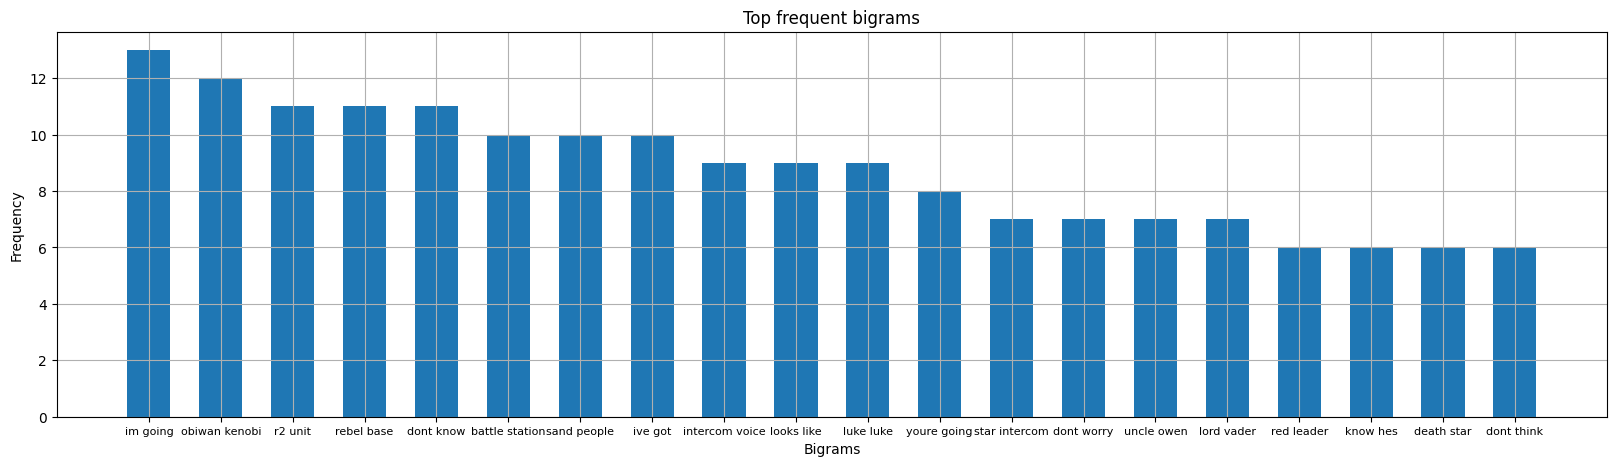

In [262]:
results_bigram_graphic(t3_local_res_e4)

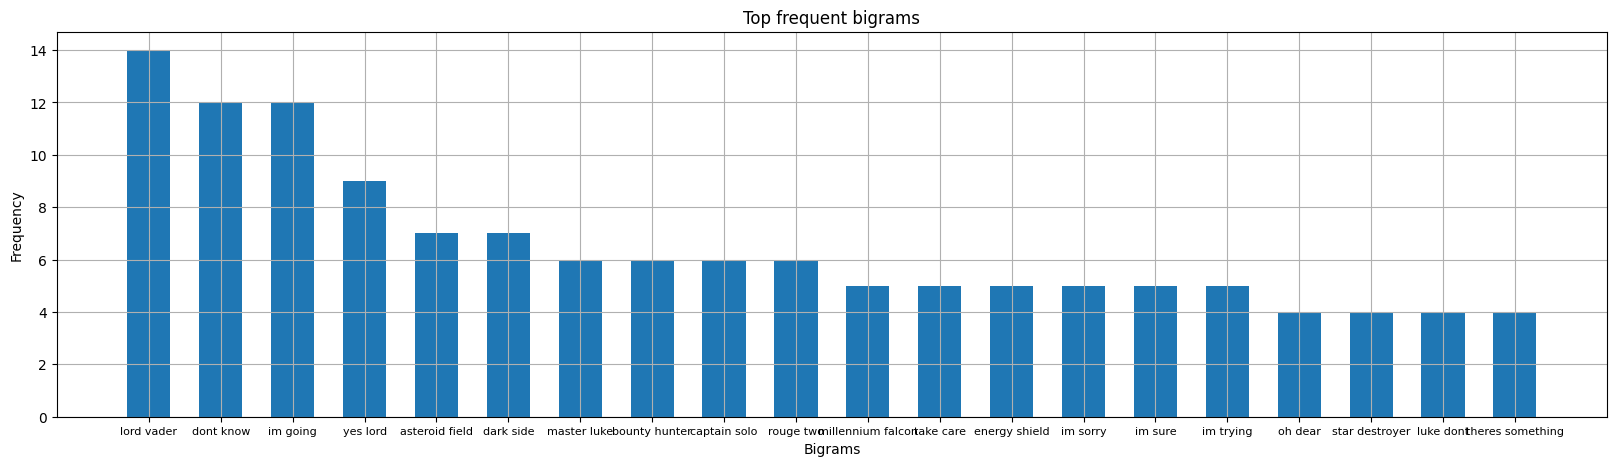

In [263]:
results_bigram_graphic(t3_local_res_e5)

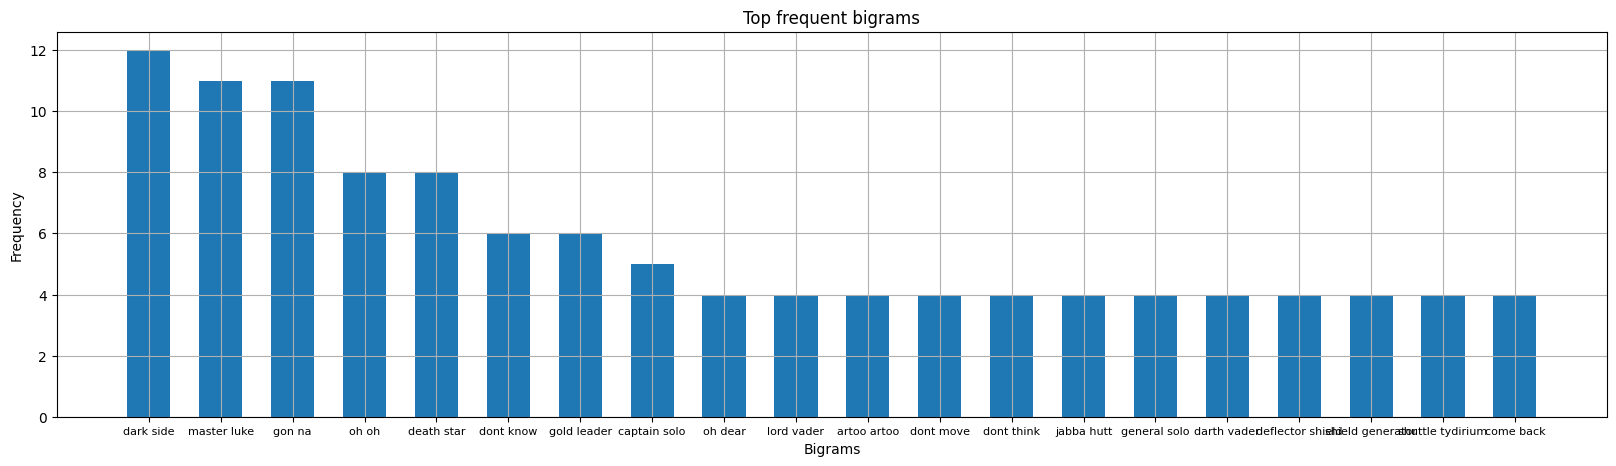

In [264]:
results_bigram_graphic(t3_local_res_e6)

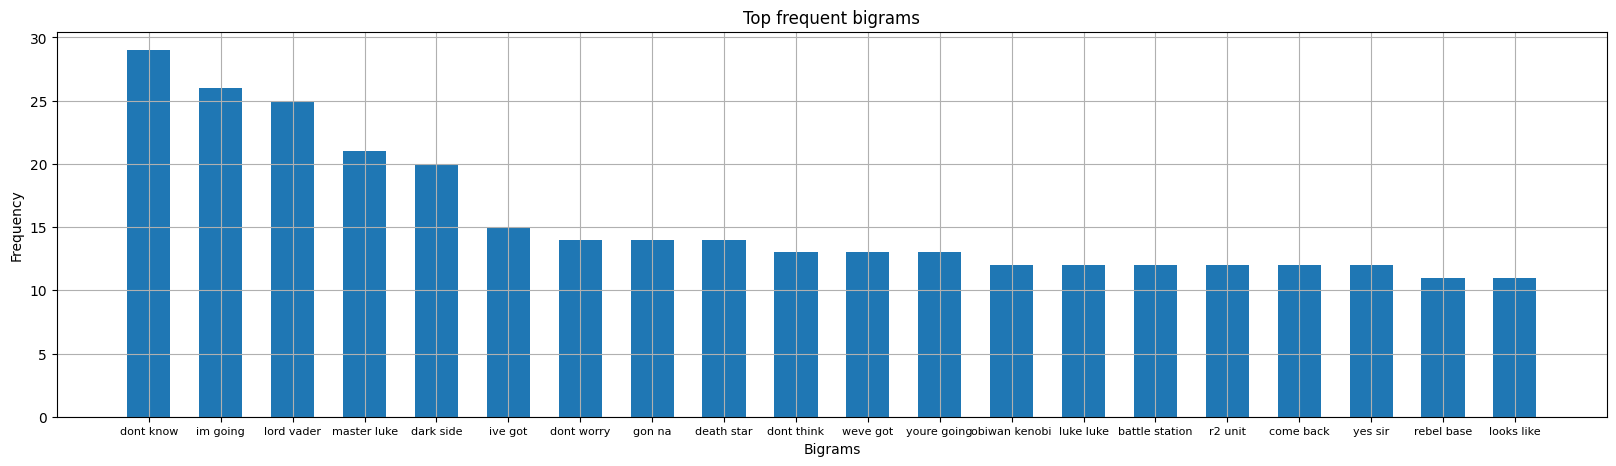

In [265]:
results_bigram_graphic(t3_local_res_all)